In [1]:
from bids import BIDSLayout
import pandas as pd
import numpy as np
import scipy
import json
import pyedflib
import re
import nibabel as nb
import os
import xarray as xr
import analysis
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.signal
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
label_test = 'extSOZ' #extSOZ
# Load the dataarray
# ds = xr.open_dataset(f"./Data/{label_test}/ds_{label_test}_freq_reduced.nc")
ds = xr.open_dataset(f"./Data/{label_test}/ds_{label_test}_full.nc")
# Update text inputs
# for coord in ['subj_chn', 'group', 'chn', 'subj']:
#     ds.coords[coord] = ds.coords[coord].astype('<U32')
# for coord in ['PD', 'AP']:
#     ds.coords[coord] = ds.coords[coord].astype('float64')
ds

<xarray.Dataset>
Dimensions:      (time: 12000, frequency: 159, n: 70, f_bands: 5)
Coordinates:
  * time         (time) float64 0.0 0.005 0.01 0.015 ... 59.98 59.98 59.99 59.99
  * frequency    (frequency) float64 0.5 1.0 1.5 2.0 2.5 ... 78.0 78.5 79.0 79.5
    subj_chn     (n) object ...
    group        (n) object ...
    chn          (n) object ...
    subj         (n) int8 ...
  * n            (n) int32 0 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67 68 69
  * f_bands      (f_bands) object 'delta' 'theta' 'alpha' 'beta' 'gamma'
Data variables:
    time_domain  (n, time) float64 ...
    psd          (n, frequency) float64 ...
    bandpow      (n, f_bands) float64 ...

### Normal signal vs abnormal

In [3]:
normal_signals = ds['time_domain'].where(ds.group=='normal', drop=True).to_numpy()
abnormal_signals = ds['time_domain'].where(ds.group=='ipsi', drop=True).to_numpy()

In [197]:
# Try for 1 signal 'normal' and 1 abnormal
signal_normal = normal_signals[np.random.choice(np.arange(normal_signals.shape[0])),:]
signal_abnormal = abnormal_signals[np.random.choice(np.arange(abnormal_signals.shape[0])),:]
signal_normal.shape, signal_abnormal.shape

((12000,), (12000,))

In [198]:
f_n, t_n, Sxx_n = scipy.signal.spectrogram(signal_normal, fs=200) # Sxx: freq x time
f_a, t_a, Sxx_a = scipy.signal.spectrogram(signal_abnormal, fs=200) # Sxx: freq x time

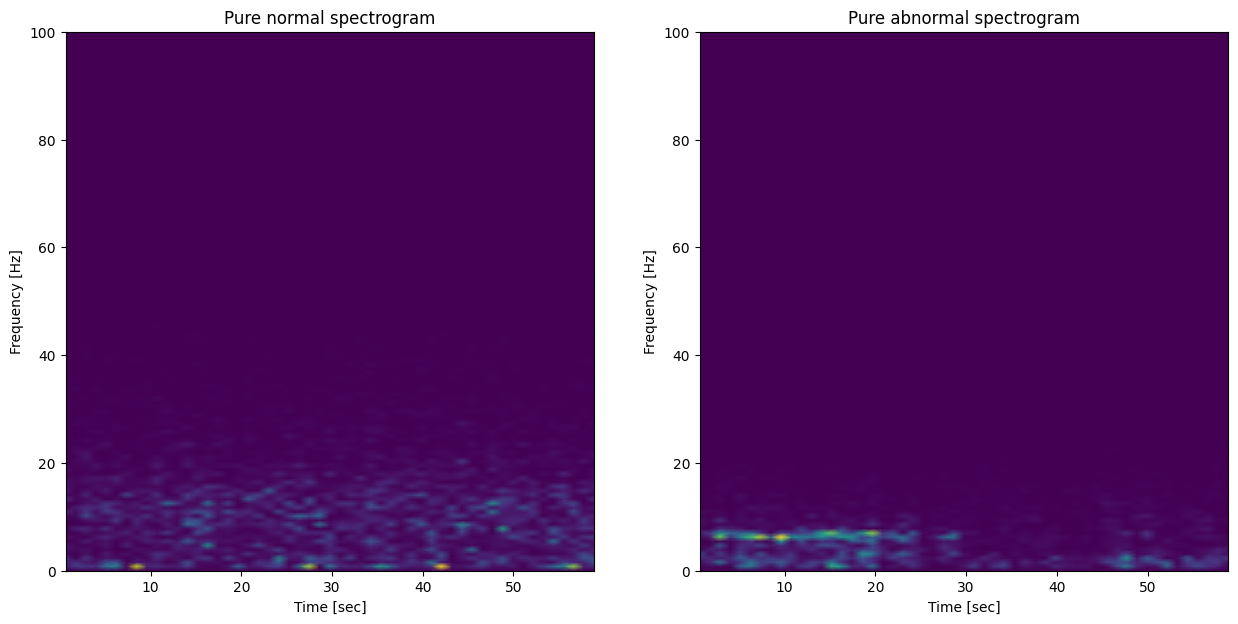

In [199]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
ax[0].pcolormesh(t_n, f_n, Sxx_n, shading='gouraud')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
ax[0].set_title('Pure normal spectrogram')
ax[1].pcolormesh(t_a, f_a, Sxx_a, shading='gouraud')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].set_title('Pure abnormal spectrogram')
plt.show()

In [200]:
# with baseline normalization
baseline_n = np.mean(Sxx_n, axis=1)
baseline_a = np.mean(Sxx_a, axis=1)
baseline_n.shape, baseline_a.shape

((129,), (129,))

In [201]:
Sxx_n_normalized = np.divide(Sxx_n, baseline_n.reshape(-1,1))
Sxx_a_normalized = np.divide(Sxx_a, baseline_a.reshape(-1,1))

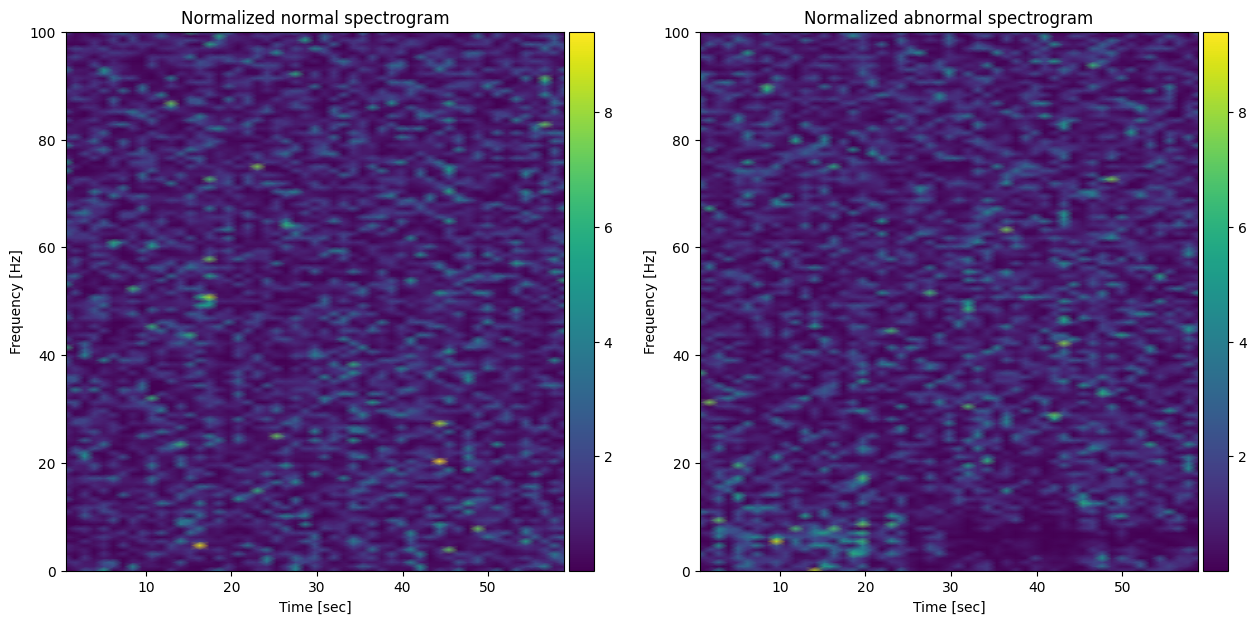

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
im1 = ax[0].pcolormesh(t_n, f_n, Sxx_n_normalized, shading='gouraud',
                       vmin = min(np.min(Sxx_n_normalized), np.min(Sxx_a_normalized)),
                       vmax = max(np.max(Sxx_n_normalized), np.max(Sxx_a_normalized)))
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
ax[0].set_title('Normalized normal spectrogram')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolormesh(t_a, f_a, Sxx_a_normalized, shading='gouraud',
                       vmin = min(np.min(Sxx_n_normalized), np.min(Sxx_a_normalized)),
                       vmax = max(np.max(Sxx_n_normalized), np.max(Sxx_a_normalized)))
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].set_title('Normalized abnormal spectrogram')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
col = fig.colorbar(im2, cax=cax, orientation='vertical')
plt.show()

In [203]:
Sxx_n_zscore = zscore(Sxx_n, axis=1)
Sxx_a_zscore = zscore(Sxx_a, axis=1)

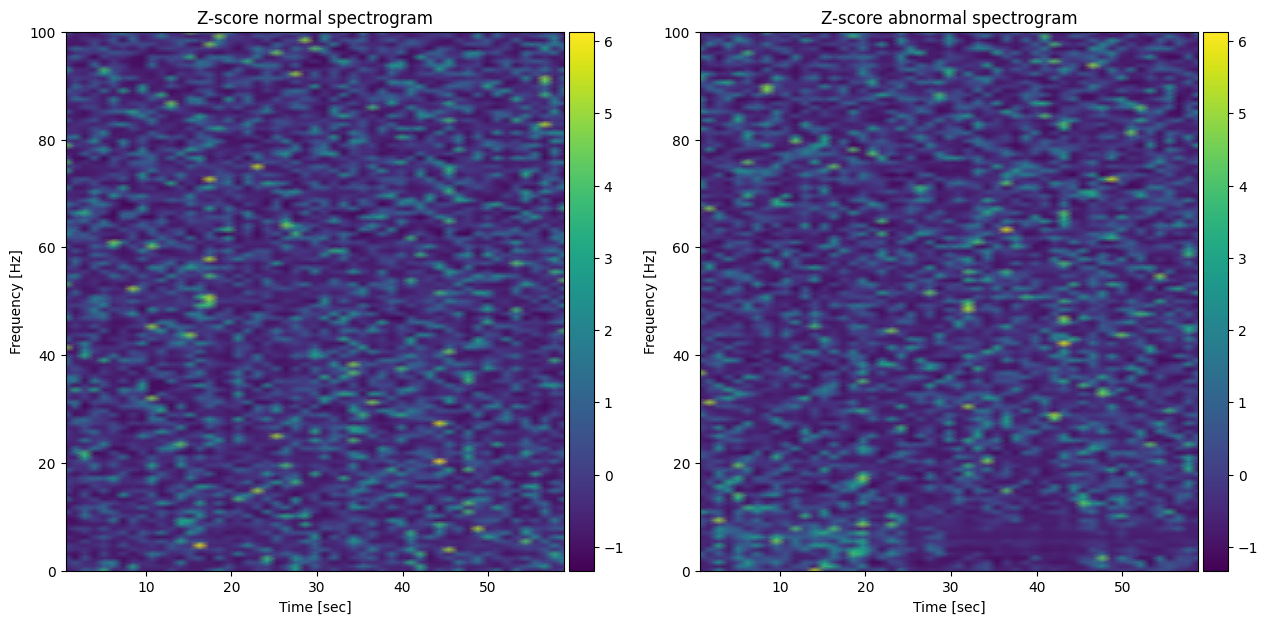

In [204]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
im1 = ax[0].pcolormesh(t_n, f_n, Sxx_n_zscore, shading='gouraud',
                       vmin = min(np.min(Sxx_n_zscore), np.min(Sxx_a_zscore)),
                       vmax = max(np.max(Sxx_n_zscore), np.max(Sxx_a_zscore)))
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
ax[0].set_title('Z-score normal spectrogram')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolormesh(t_a, f_a, Sxx_a_zscore, shading='gouraud', 
                       vmin = min(np.min(Sxx_n_zscore), np.min(Sxx_a_zscore)),
                       vmax = max(np.max(Sxx_n_zscore), np.max(Sxx_a_zscore)))
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].set_title('Z-score abnormal spectrogram')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
col = fig.colorbar(im2, cax=cax, orientation='vertical')
plt.show()

### Make it a workflow


In [11]:
normal_signals = ds['time_domain'].where(ds.group=='normal', drop=True).to_numpy()
abnormal_signals = ds['time_domain'].where(ds.group=='ipsi', drop=True).to_numpy()

In [23]:
groups = ['normal', 'ipsi']
small_id = np.argmin([normal_signals.shape[0], abnormal_signals.shape[0]])
small_group_signals = ds['time_domain'].where(ds.group==groups[small_id], drop=True).to_numpy()
big_group_signals = ds['time_domain'].where(ds.group==groups[small_id-1], drop=True).to_numpy()

In [25]:
big_ids = list(range(big_group_signals.shape[0]))
for i in np.arange(small_group_signals.shape[0]):
    # Get signals
    signal_small = small_group_signals[i,:]
    id_big_sig = np.random.choice(big_ids)
    big_ids.remove(id_big_sig)
    signal_big = big_group_signals[id_big_sig,:]
    # Get spectrogram
    f_n, t_n, Sxx_n = scipy.signal.spectrogram(signal_small, fs=200) # Sxx: freq x time
    f_a, t_a, Sxx_a = scipy.signal.spectrogram(signal_big, fs=200) # Sxx: freq x time
    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    ax[0].pcolormesh(t_n, f_n, Sxx_n, shading='gouraud')
    ax[0].set_ylabel('Frequency [Hz]')
    ax[0].set_xlabel('Time [sec]')
    ax[0].set_title(f'Pure {groups[small_id]} spectrogram')
    ax[1].pcolormesh(t_a, f_a, Sxx_a, shading='gouraud')
    ax[1].set_ylabel('Frequency [Hz]')
    ax[1].set_xlabel('Time [sec]')
    ax[1].set_title(f'Pure {groups[small_id-1]} spectrogram')
    plt.savefig(f'./Spectrum_comparison/Pure_spectrogram_{i}.png')
    plt.close()
    
    # with baseline normalization
    baseline_n = np.mean(Sxx_n, axis=1)
    baseline_a = np.mean(Sxx_a, axis=1)
    # baseline_n.shape, baseline_a.shape
    Sxx_n_normalized = np.divide(Sxx_n, baseline_n.reshape(-1,1))
    Sxx_a_normalized = np.divide(Sxx_a, baseline_a.reshape(-1,1))
    
    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    im1 = ax[0].pcolormesh(t_n, f_n, Sxx_n_normalized, shading='gouraud',
                           vmin = min(np.min(Sxx_n_normalized), np.min(Sxx_a_normalized)),
                           vmax = max(np.max(Sxx_n_normalized), np.max(Sxx_a_normalized)))
    ax[0].set_ylabel('Frequency [Hz]')
    ax[0].set_xlabel('Time [sec]')
    ax[0].set_title(f'Normalized {groups[small_id]} spectrogram')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    im2 = ax[1].pcolormesh(t_a, f_a, Sxx_a_normalized, shading='gouraud',
                           vmin = min(np.min(Sxx_n_normalized), np.min(Sxx_a_normalized)),
                           vmax = max(np.max(Sxx_n_normalized), np.max(Sxx_a_normalized)))
    ax[1].set_ylabel('Frequency [Hz]')
    ax[1].set_xlabel('Time [sec]')
    ax[1].set_title(f'Normalized {groups[small_id-1]} spectrogram')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    col = fig.colorbar(im2, cax=cax, orientation='vertical')
    plt.savefig(f'./Spectrum_comparison/Normalized_spectrogram_{i}.png')
    plt.close()
    
    # Z-score
    Sxx_n_zscore = zscore(Sxx_n, axis=1)
    Sxx_a_zscore = zscore(Sxx_a, axis=1)
    #Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    im1 = ax[0].pcolormesh(t_n, f_n, Sxx_n_zscore, shading='gouraud',
                           vmin = min(np.min(Sxx_n_zscore), np.min(Sxx_a_zscore)),
                           vmax = max(np.max(Sxx_n_zscore), np.max(Sxx_a_zscore)))
    ax[0].set_ylabel('Frequency [Hz]')
    ax[0].set_xlabel('Time [sec]')
    ax[0].set_title(f'Z-score {groups[small_id]} spectrogram')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    im2 = ax[1].pcolormesh(t_a, f_a, Sxx_a_zscore, shading='gouraud', 
                           vmin = min(np.min(Sxx_n_zscore), np.min(Sxx_a_zscore)),
                           vmax = max(np.max(Sxx_n_zscore), np.max(Sxx_a_zscore)))
    ax[1].set_ylabel('Frequency [Hz]')
    ax[1].set_xlabel('Time [sec]')
    ax[1].set_title(f'Z-score {groups[small_id-1]} spectrogram')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    col = fig.colorbar(im2, cax=cax, orientation='vertical')
    plt.savefig(f'./Spectrum_comparison/Zscore_spectrogram_{i}.png')
    plt.close()